In [1]:
import os
import glob
import yaml
import uproot
import vector
import fnmatch
import awkward as ak
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-notebook')
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate
from tqdm.notebook import tqdm
from typing import Callable, Union
import itertools

import torch
import torch.nn as nn
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, NNConv, global_add_pool, global_mean_pool, MetaLayer, MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
#from torch_scatter import scatter
import networkx as nx

2.0.1


In [2]:
dm = ak.Array([[10,11,0], [11,20,0,0]])
dm_dummy = ak.zeros_like(dm)

dm_1 = ak.where(dm == 1, dm, dm_dummy)
dm_1

<Array [[0, 0, 0], [0, 0, 0, 0]] type='2 * var * int64'>

In [3]:
uni = np.unique(ak.ravel(dm))
uni

<Array [0, 10, 11, 20] type='4 * int64'>

In [4]:
for val in uni:
    if val == 0: 
        continue
    d = ak.where(dm == val, ak.ones_like(dm), ak.zeros_like(dm))
    print(val-10, d)

0 [[1, 0, 0], [0, 0, 0, 0]]
1 [[0, 1, 0], [1, 0, 0, 0]]
10 [[0, 0, 0], [0, 1, 0, 0]]


In [5]:
a = ak.Array([[10,10,10],[10,10],[10,10,20,10],[10,20,10]])
mean = ak.mean(a, axis=0)
std = ak.std(a, axis=1)

mean, std
#a-mean

(<Array [10, 12.5, 13.3, 10] type='4 * ?float64'>,
 <Array [0, 0, 4.33, 4.71] type='4 * ?float64'>)

In [6]:
b = ak.Array([[48,28.7,71.5], [40.4,32.2], [40.4,32.2,21.5,11.2,9.1]])
#b = ak.concatenate([b, b], axis=0)
#a = ak.Array([[4,4,4], [4,4],[4,4]])
m = ak.mean(b, axis=0)
s = 0#ak.std(b, axis=0)
m, s

(<Array [42.9, 31, 46.5, 11.2, 9.1] type='5 * ?float64'>, 0)

In [7]:
print(b)
counts = ak.max(ak.count(b, axis=1))
scaled_ak = None
for i in range(counts):
    b_i = b[:,i:i+1]
    print(i,b_i)
    mean = ak.mean(b_i)
    print("mean: ",mean)
    std = ak.std(b_i)
    print("std: ", std)
    print("arr - mean", b_i - mean)
    print("arr - mean/ std", (b_i - mean)/std)
    scaled = (b_i - mean)/std if std != 0.0 else (b_i - mean)
    print("scaled: ", scaled)
    scaled_ak = scaled if i == 0 else ak.concatenate([scaled_ak, scaled], axis=1)
scaled_ak

[[48, 28.7, 71.5], [40.4, 32.2], [40.4, 32.2, 21.5, 11.2, 9.1]]
0 [[48], [40.4], [40.4]]
mean:  42.93333333333334
std:  3.582674358011841
arr - mean [[5.07], [-2.53], [-2.53]]
arr - mean/ std [[1.41], [-0.707], [-0.707]]
scaled:  [[1.41], [-0.707], [-0.707]]
1 [[28.7], [32.2], [32.2]]
mean:  31.033333333333335
std:  1.6499158227686126
arr - mean [[-2.33], [1.17], [1.17]]
arr - mean/ std [[-1.41], [0.707], [0.707]]
scaled:  [[-1.41], [0.707], [0.707]]
2 [[71.5], [], [21.5]]
mean:  46.5
std:  25.0
arr - mean [[25], [], [-25]]
arr - mean/ std [[1], [], [-1]]
scaled:  [[1], [], [-1]]
3 [[], [], [11.2]]
mean:  11.2
std:  0.0
arr - mean [[], [], [0]]
arr - mean/ std [[], [], [nan]]
scaled:  [[], [], [0]]
4 [[], [], [9.1]]
mean:  9.1
std:  0.0
arr - mean [[], [], [0]]
arr - mean/ std [[], [], [nan]]
scaled:  [[], [], [0]]


/Users/gsaha/anaconda3/envs/PyTorchEnv/lib/python3.11/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


<Array [[1.41, -1.41, 1], ... 0.707, -1, 0, 0]] type='3 * var * float64'>

In [8]:
b[1], scaled_ak[1]

(<Array [40.4, 32.2] type='2 * float64'>,
 <Array [-0.707, 0.707] type='2 * float64'>)

In [9]:
norm[2]

NameError: name 'norm' is not defined

In [10]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [11]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device

In [12]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [13]:
device = torch.device("mps")
device

device(type='mps')

In [14]:
def getp4(df, vars=[], LVtype=""):
    """
        df: The main dfataframe
        vars = [p4 components of obj]
        LVtype = ptetaphim / pxpypze
    """
    for var in vars:
        if var not in list(df.keys()):
            df[var] = 0.0
    p4 = None
    if LVtype == "ptetaphim":
        p4 = vector.array({"pt": df[vars[0]].to_numpy(),
                           "eta": df[vars[1]].to_numpy(),
                           "phi": df[vars[2]].to_numpy(),
                           "M": df[vars[3]].to_numpy()})
    elif LVtype == "pxpypze":
        p4 = vector.array({"px": df[vars[0]].to_numpy(),
                           "py": df[vars[1]].to_numpy(),
                           "pz": df[vars[2]].to_numpy(),
                           "E": df[vars[3]].to_numpy()})


    return p4

In [15]:
torch.cuda.is_available()

False

In [16]:
a = 15
int(np.ceil(np.sqrt(a)))

4

## Read Dataframe 

In [17]:
#pdfile = "df_DY_v5_processed.h5"
#pqfile = "DY_records_v2.parquet"
#events_record = ak.from_parquet(pqfile)
#events_record

In [18]:
node_pqt = "DY_Cat_norm_20231206_162021/DY_nodes.parquet"
target_pqt = "DY_Cat_norm_20231206_162021/DY_targets.parquet"
global_pqt = "DY_Cat_norm_20231206_162021/DY_globals.parquet"

In [19]:
node_info = ak.from_parquet(node_pqt)
target_info = ak.from_parquet(target_pqt)
global_info = ak.from_parquet(global_pqt)

In [20]:
node_info.fields

['pt',
 'eta',
 'phi',
 'mass',
 'dxy',
 'dz',
 'rawDeepTau2017v2p1VSe',
 'rawDeepTau2017v2p1VSjet',
 'rawDeepTau2017v2p1VSmu',
 'rawIsodR03',
 'rawMVAnewDM2017v2',
 'leadTkPtOverTauPt',
 'btagDeepFlavB',
 'charge_9',
 'charge_11',
 'decayMode_10',
 'decayMode_11',
 'decayMode_20',
 'decayMode_21']

In [21]:
events_record = {}
events_record["node_feats"] = node_info
events_record["target_feats"] = target_info
events_record["global_feats"] = global_info
events_record

{'node_feats': <Array [[{pt: 0.843, ... decayMode_21: 0}]] type='599094 * var * {"pt": float32,...'>,
 'target_feats': <Array [[{px: -5.95, py: 9.62, ... pz: -1.08}]] type='599094 * var * {"px": ?flo...'>,
 'global_feats': <Array [{met_pt: -0.108, ... mt_total: 0.0943}] type='599094 * {"met_pt": float3...'>}

In [22]:
#node_record = {key.replace('node_',''):ak.firsts(events_record[key], axis=0) for key in events_record.fields if key.split('_')[0]=='node'}
#node_record

In [23]:
events_record["global_feats"].fields

['met_pt',
 'met_phi',
 'met_covxx',
 'met_covxy',
 'met_covyy',
 'met_sumet',
 'met_significance',
 'njet',
 'npv',
 'ht',
 'mt_tau1_met',
 'mt_tau2_met',
 'mt_tau1_tau2',
 'mt_total']

In [24]:
#temp= ak.firsts(events_record.node_feats, axis=0)
#temp.pt

In [25]:
#ak.count(ak.firsts(events_record.global_feats["met_pt"], axis=0))

In [26]:
#node_record = ak.firsts(events_record["node_feats"], axis=0)
#global_record = ak.firsts(events_record["global_feats"], axis=0)
#target_record = ak.firsts(events_record["target_feats"], axis=0)

In [27]:
#node_record

In [28]:
from util import PlotUtil

In [34]:
plotter = PlotUtil(events_record)

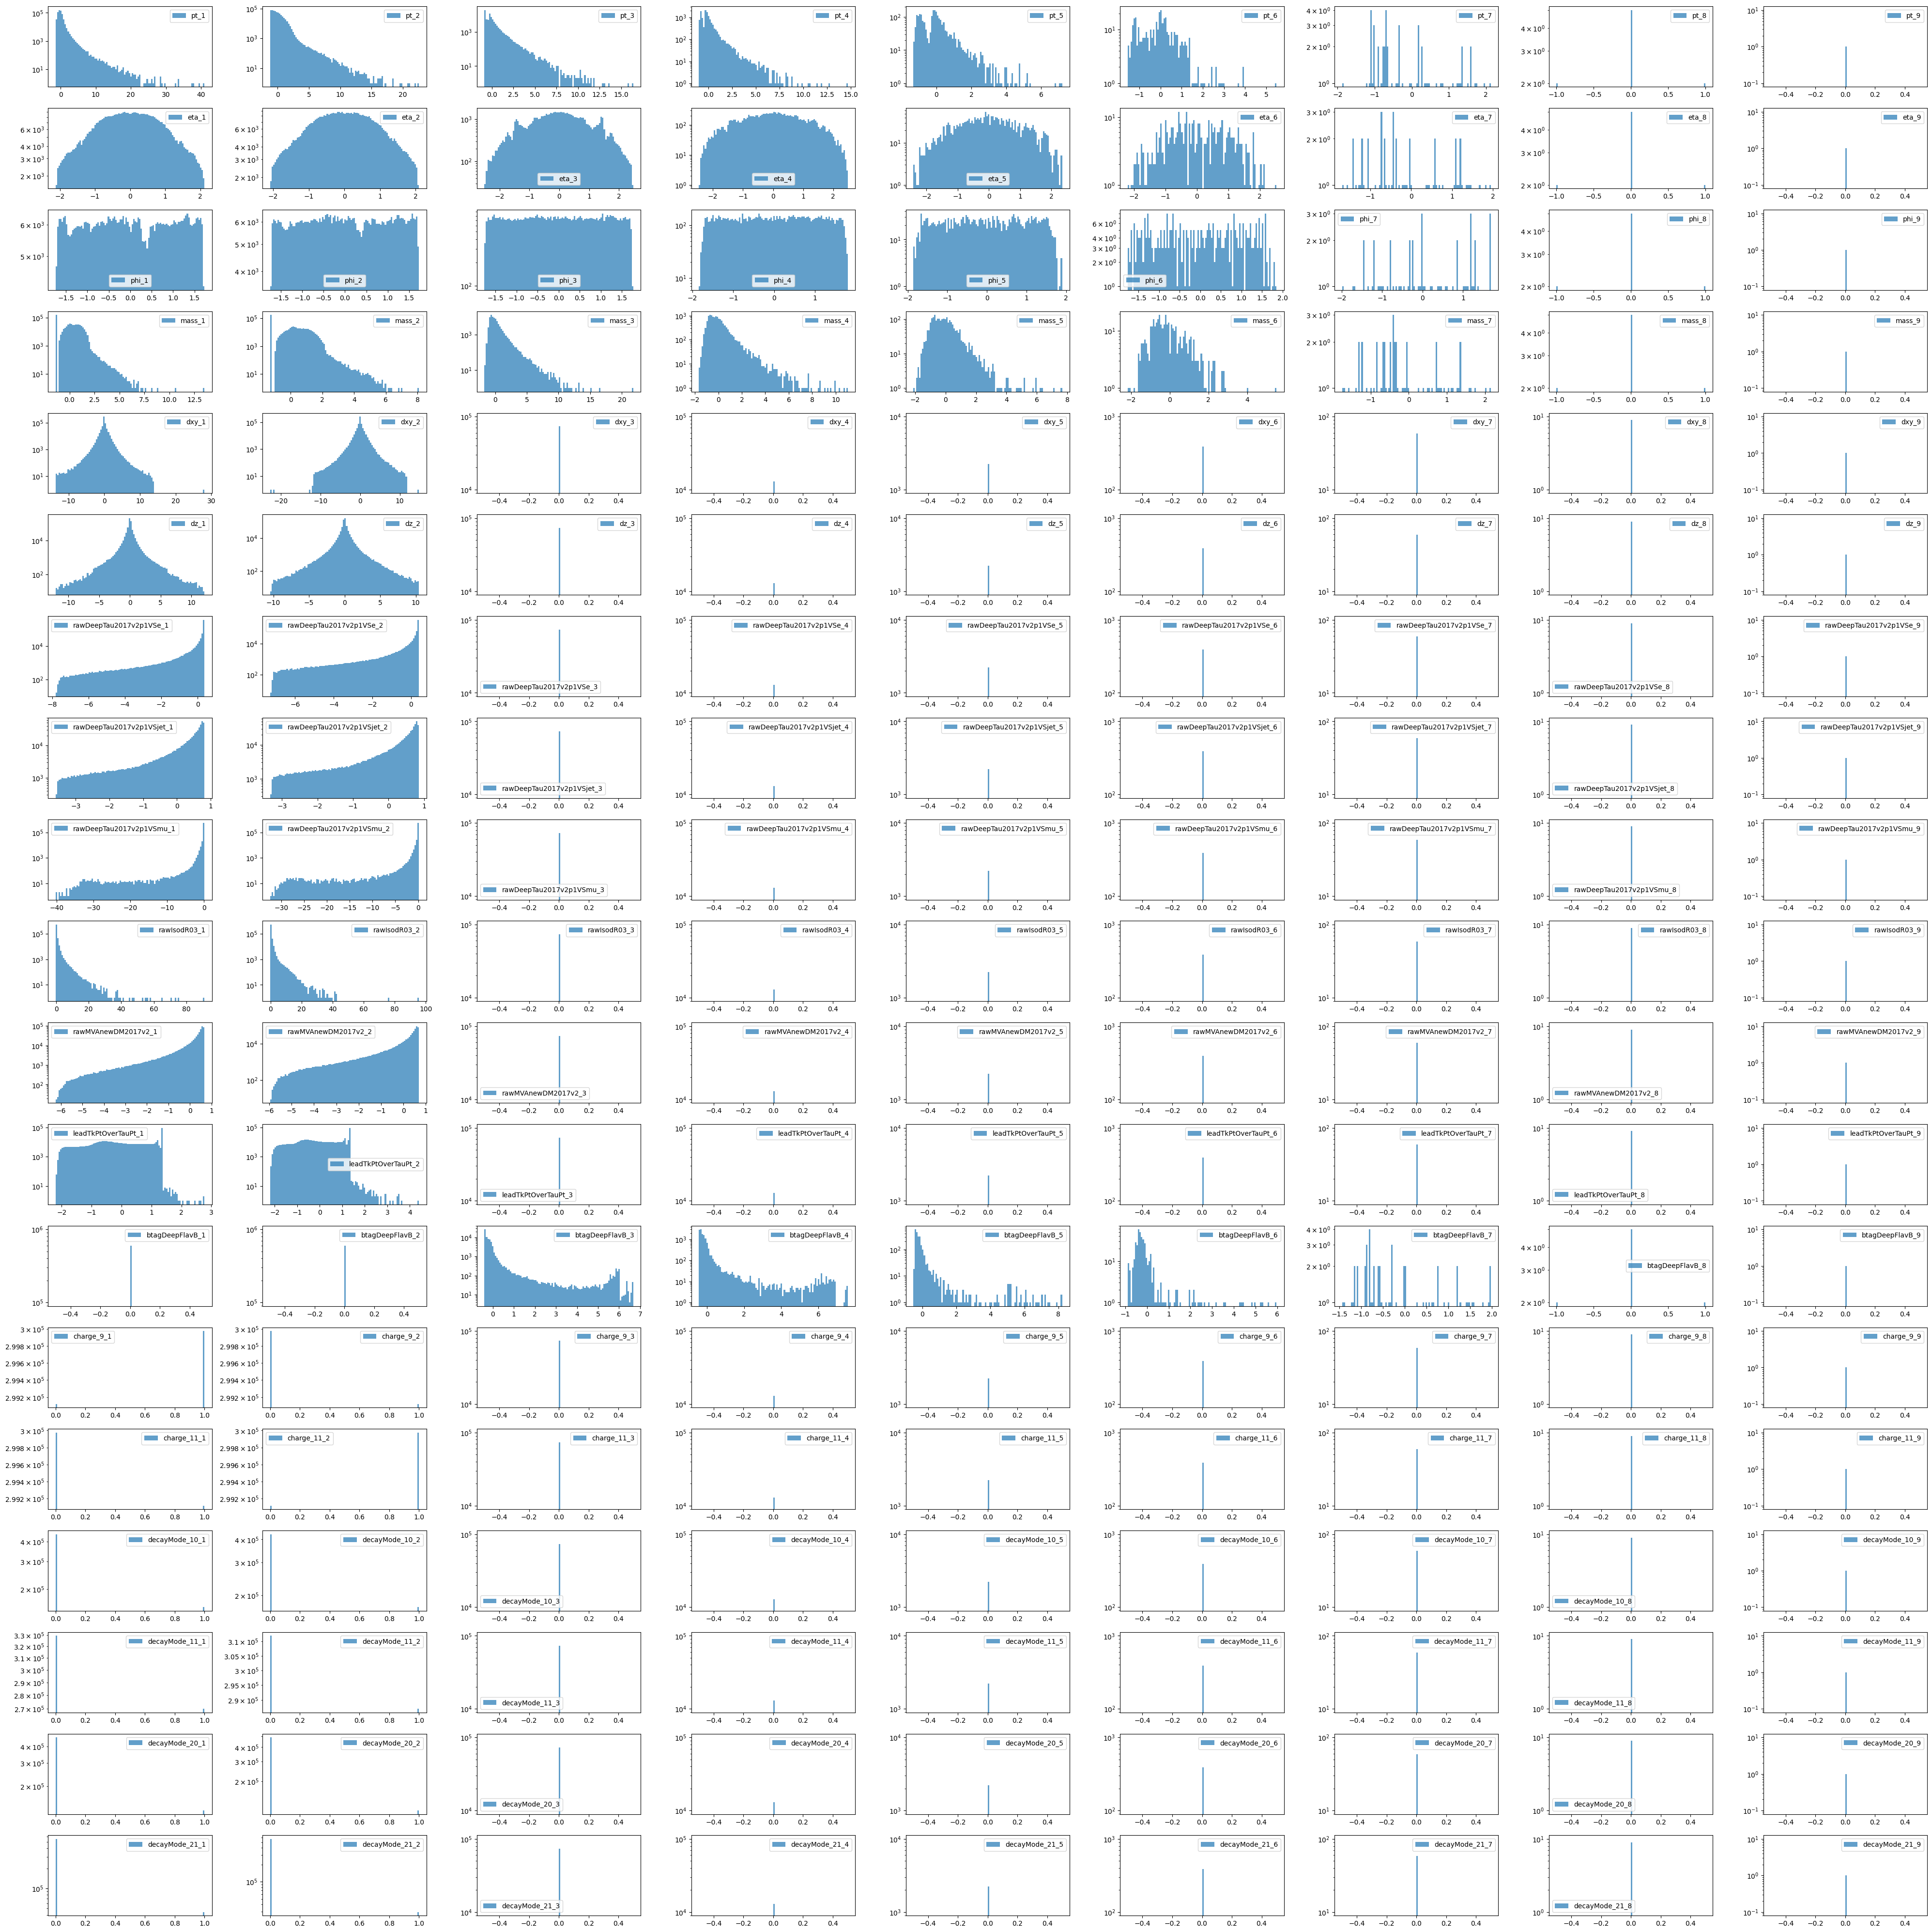

In [35]:
plt = plotter.plot_nodes((40,40))

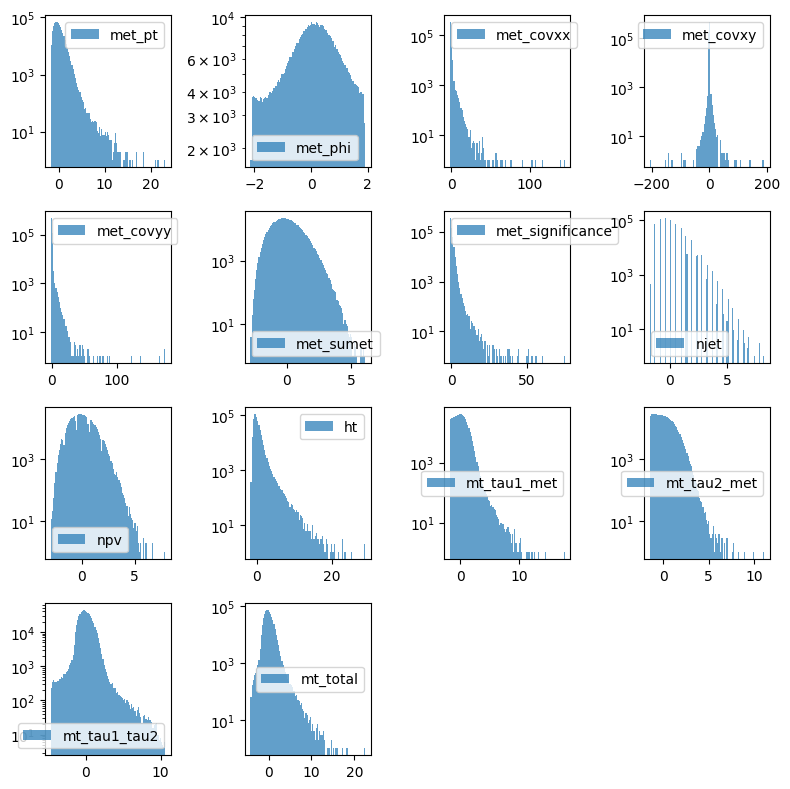

In [36]:
plt = plotter.plot_globals()

In [29]:
class ZtoTauTauDataset(Dataset):
    def __init__(self, events_record):
        super(ZtoTauTauDataset, self).__init__()

        #self.root = os.path.join(os.getcwd(),"Datasets")
        #self.node_record = {key.replace('node_',''):ak.firsts(events_record[key], axis=0) for key in events_record.fields if key.split('_')[0]=='node'}
        #self.target_record = {key.replace('node_',''):ak.firsts(events_record[key], axis=0) for key in events_record.fields if key.split('_')[0]=='target'}
        #self.global_record = {key.replace('node_',''):ak.firsts(events_record[key], axis=0) for key in events_record.fields if key.split('_')[0]=='global'}
        self.node_record = events_record["node_feats"]
        self.target_record = events_record["target_feats"]
        self.global_record = events_record["global_feats"]
        globals = events_record["global_feats"].fields
        self.num_entries = ak.count(events_record["global_feats"][globals[0]])
        #self.num_entries = ak.count(ak.firsts(events_record.global_met_pt, axis=0))
        
    def transform_to_torch(self, idx):
        xs = []
        ys = []
        aux_ys = []
        us = []

        nodes_p4 = ak.zip(
            {
                "pt": self.node_record["pt"][idx:idx+1],
                "eta": self.node_record["eta"][idx:idx+1],
                "phi": self.node_record["phi"][idx:idx+1],
                "mass": self.node_record["mass"][idx:idx+1],
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )
        nodes_p4 = ak.firsts(nodes_p4, axis=0)
        #print(f"nodes_p4: {nodes_p4}")
        
        #for node_key in self.node_record.fields:
        for node_key in ["pt", "eta", "phi", "mass", "charge"]:
            node_val = self.node_record[node_key]
            temp_x = ak.firsts(node_val[idx:idx+1], axis=0).to_numpy()
            xs.append(temp_x)

        node_feats = np.stack(xs).T
        #print(f"node_feats: {node_feats}")

        node_x = torch.tensor(node_feats).to(torch.float32)
        #node_x = node_x.to(device)
        #print(f"Tensor: node_feats: {node_x}")

        # preparing edges
        nodeidxs = list(range(node_feats.shape[0]))
        edgeidxs = []
        for pair in list(itertools.combinations(nodeidxs, 2)):
            pair = list(pair)
            edgeidxs.append(pair)
            edgeidxs.append(pair[::-1])
        edgeidxs = torch.tensor(edgeidxs).to(torch.long)
        #edgeidxs = edgeidxs.to(device)
        #print(f"edge_idxs: {edgeidxs}")

        src, dst = edgeidxs[:,0].cpu().detach().numpy(), edgeidxs[:,1].cpu().detach().numpy()
        #print(f"src: {src}, dst: {dst}")
        
        edges_dr = torch.tensor(nodes_p4[src].delta_r(nodes_p4[dst])).to(torch.float32)
        edges_attr = edges_dr.reshape(-1,1)
        #edges_attr = edges_attr.to(device)
        #print(f"edges_dr : {edges_attr}")
        
        for target_key in self.target_record.fields:
            target_val = self.target_record[target_key]
            temp_y = ak.firsts(target_val[idx:idx+1], axis=0).to_numpy()
            ys.append(temp_y[:2])
            aux_ys.append(temp_y[2:])
        target_feats = np.stack(ys).T
        #print(f"target_feats: {target_feats}")
        target_y = torch.tensor(target_feats).to(torch.float32)
        target_y = target_y.reshape(1,int(target_y.shape[0]*target_y.shape[1]))
        #target_y = target_y.to(device)
        #print(f"Tensor: target_feats: {target_y}")

        aux = np.stack(aux_ys).T
        aux = torch.tensor(aux).to(torch.float32)
        #aux = aux.to(device)
        #print(f"aux: {aux}")

        for global_key in self.global_record.fields:
            global_val = self.global_record[global_key]
            temp_x = global_val[idx:idx+1].to_numpy()
            us.append(temp_x)
        #print(us)
        #print(f"global_feats: {us}")
        global_u = torch.tensor(np.array(us)).to(torch.float32).reshape(1,-1)
        #global_u = global_u.to(device)
        #print(f"Tensor: global_feats: {global_u}")


        #print(f"Types: {type(node_x)}\n{type(edgeidxs)}\n{type(edges_attr)}\n{type(target_y)}\n{type(global_u)}\n{type(aux)}")
        data = Data(x=node_x,
                    edge_index = edgeidxs.t().contiguous(),
                    edge_attr = edges_attr,
                    y=target_y,
                    u=global_u)

        data.aux_gentaus = aux
        #print(f"{type(data)}")
        return data

    
    def len(self):
        return self.num_entries

    def get(self, idx):
        return self.transform_to_torch(idx)


In [30]:
dataset = ZtoTauTauDataset(events_record)

In [31]:
for i in range(10):
    data = dataset.get(i)
    print(data)
    #print(data.get_device())

ValueError: key "charge" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.4/src/libawkward/util.cpp#L525)

In [32]:
dataset.len()

599094

In [33]:
data=dataset[480].cpu()
nxg = to_networkx(data)
print(nxg.nodes)
print(data.x, data.num_node_features, data.x.shape[0])

pos = {i: (data.x[i, 1], data.x[i, 2]) for i in nxg.nodes}

plt.figure(figsize=(6, 4))
ax = plt.axes()
nx.draw_networkx(nxg, pos, with_labels=True, arrows=True, node_size=10*data.x[:, 0], node_shape="o", ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ValueError: key "charge" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.4/src/libawkward/util.cpp#L525)

In [ ]:
from torch_geometric.utils import to_dense_adj
dense_adj = to_dense_adj(data.edge_index)

plt.figure(figsize=(6,5))
plt.imshow(dense_adj[0], interpolation="none", cmap="Blues")
plt.colorbar()
plt.xlabel("Node index $i$")
plt.ylabel("Node index $j$")
plt.title("Graph adjacency matrix")

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:100000]
test_dataset = dataset[100000:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [ ]:
len(train_loader)

In [ ]:
#for i in range(len(train_loader)):
for i in range(100):
    loader = next(iter(train_loader))
    print(i, loader)

In [ ]:
for i,data_batched in enumerate(train_loader):
    #data_batched = data_batched.to(device)
    print(f"Batch idx: {i}")
    print(data_batched)
    
    #print(f"data batch: {data_batched.batch}")
    print(f"node_shape: {data_batched.x.shape}")
    print(f"target shape: {data_batched.y.shape}")
    print(f"edge idx shape: {data_batched.edge_index.shape}")
    print(f"edge attr shape: {data_batched.edge_attr.shape}")
    print(f"global shape: {data_batched.u.shape}")
    #print(data_batched.x, data_batched.y)
    
    if i>0:
        break

In [ ]:
data_batched = data_batched.cpu()
dense_adj = to_dense_adj(data_batched.edge_index)

plt.figure(figsize=(6,5))
plt.imshow(dense_adj[0], interpolation="none", cmap="Blues")
plt.colorbar()
plt.xlabel("Node index $i$")
plt.xlabel("Node index $j$")
plt.title("Graph adjacency matrix")

## Model building 

In [ ]:
### ------ ###
### MLP to extend the embedding dimentsion of each nodes 
### Then apply edge convolution to update the node embeddings again
### 

In [ ]:
# Node model
class GATConvBlock(torch.nn.Module):
    def __init__(self, dim_in: int, dim_h: int, dim_out: int, heads: int = 5):
        super(GATConvBlock, self).__init__()
        
        self.gat1 = GATConv(dim_in, dim_h, heads=heads)
        self.gat2 = GATConv(dim_h*heads, dim_out, heads=1)
        
    def forward(self, x, edge_index, edge_attr):
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        #x = F.batch_norm(x, training=self.training)
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        #x = F.batch_norm(x, training=self.training)
        
        return x

In [ ]:
# Edge model
# build a mlp for edge convolution
def build_mlp(in_size, layer_size, depth):
    layers = []

    layers.append(nn.Linear(in_size * 2, layer_size))
    layers.append(nn.BatchNorm1d(layer_size))
    layers.append(nn.ReLU())

    for i in range(depth):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.BatchNorm1d(layer_size))
        layers.append(nn.ReLU())

    return nn.Sequential(*layers)

# build the conv layer
class EdgeConv_lrp(MessagePassing):
    def __init__(self, nn: Callable, aggr: str = "max", **kwargs):
        super(EdgeConv_lrp, self).__init__(aggr=aggr, **kwargs)
        self.nn = nn
        
    def forward(self, x, edge_index):
        return (
            self.propagate(edge_index, x=x),
            self.edge_activations
        )
    
    def message(self, x_i, x_j):
        self.edge_activations = self.nn(torch.cat([x_i, x_j], dim=-1))
        return self.nn(torch.cat([x_i, x_j], dim=-1))

    def __repr__(self):
        return f"{self.__class__.__name__}(nn={self.nn})"
    
# build edge model
class EdgeConvBlock(torch.nn.Module):
    def __init__(self, in_size, layer_size, depth):
        super(EdgeConvBlock, self).__init__()
        
        edge_mlp = build_mlp(in_size=in_size, layer_size=layer_size, depth=depth)
        self.edge_conv = EdgeConv_lrp(edge_mlp, aggr="mean")

    def forward(self, x, edge_index):
        return self.edge_conv(x, edge_index)

In [ ]:
# build the graph model
# GAT using node and original edge feat to embed more info
# Edge convolution using those node embeddings

class NuNet(torch.nn.Module):
    def __init__(self, 
                 node_feat_size,
                 global_feat_size,
                 num_classes=6,
                 depth=2,
                 dropout=False):
        super(NuNet, self).__init__()
        
        self.node_feat_size = node_feat_size
        self.global_feat_size = global_feat_size
        self.num_classes = num_classes

        self.num_edge_conv_blocks = 2
        
        self.kernel_sizes = [2*self.node_feat_size, 128, 256]
        self.input_sizes = np.cumsum(self.kernel_sizes)
        self.fc_size = 256

        if dropout:
            self.dropout = 0.1
            self.dropout_layer = nn.Dropout(p=self.dropout)
        else:
            self.dropout = None
            
        # node conv block
        self.nodeblock = GATConvBlock(self.node_feat_size, 2*self.node_feat_size, 2*self.node_feat_size)
        
        # define the edgeconvblocks
        self.edge_conv_blocks = torch.nn.ModuleList()
        for i in range(self.num_edge_conv_blocks):
            self.edge_conv_blocks.append(EdgeConvBlock(self.input_sizes[i], self.kernel_sizes[i + 1], depth=depth))
            
        # define the fully connected networks (post-edgeconvs)
        self.fc1 = nn.Linear(self.input_sizes[-1]+global_feat_size, self.fc_size)
        self.fc2 = nn.Linear(self.fc_size, self.num_classes)
        
    def forward(self, batch):
        x  = batch.x
        y  = batch.y
        u  = batch.u
        ei = batch.edge_index
        ea = batch.edge_attr
        batch = batch.batch
        
        x = self.nodeblock(x, ei, ea)
        for i in range(self.num_edge_conv_blocks):
            out, _ = self.edge_conv_blocks[i](x, ei)
            x = torch.cat((out, x), dim=1)
            
        x = global_mean_pool(x, batch)
        #print(x.shape)
        #print(u.shape)
        x = torch.cat((x, u), dim=1)
        
        #x = F.batch_norm(x)
        
        x = self.fc1(x)
        x = F.elu(x)
        if self.dropout:
            x = self.dropout_layer(x)
        #x = F.batch_norm(x, training=self.training, momentum=0.9)
        #x = self.dropout()
        
        x = self.fc2(x)
        
        return x

In [ ]:
#gr_b = next(iter(train_loader))
#gr_b

In [ ]:
model_kwargs = {
        "node_feat_size": 5,
        "global_feat_size": 14,
        "num_classes": 6,
        "depth": 2,
        "dropout": True,
    }

model = NuNet(**model_kwargs)
#model = model.to(device)

In [ ]:
#out = model(gr_b.to(device))

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    total_nontr_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            total_nontr_params += parameter.numel()
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    print(f"Total Non-Trainable Params: {total_nontr_params}")
    return total_params
    
count_parameters(model)

Now, Model is Ready. Also, the training and test data loaders are also batched.

### PyTorch Lightning 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

In [ ]:
def train(data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

def validation(data):
    out = model(data)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss solely based on the training nodes.
    return loss

train_loss_per_epoch = []
test_loss_per_epoch = []
for epoch in range(1, 2):
    loss_train_epoch = []
    loss_val_epoch = []
    print(f"Epoch: {epoch}")
    for i,data_batched in enumerate(train_loader):
        #loss = train(data_batched.to(device))
        loss = train(data_batched)
        loss_train_epoch.append(loss.item())
        print(f"\tBatch: {i} \t Loss: {loss}")
    for i,data_batched in enumerate(test_loader):
        loss = validation(data_batched)
        #loss = validation(data_batched.to(device))
        loss_val_epoch.append(loss.item())
        
    loss_train = np.mean(loss_train_epoch)
    train_loss_per_epoch.append(loss_train)
    loss_val = np.mean(loss_val_epoch)
    test_loss_per_epoch.append(loss_val)
    #print(epoch, loss_train_epoch)
    print(f'Epoch: {epoch}, Loss_train: {loss_train:.4f}, Loss_val: {loss_val:.4f}')

In [ ]:
model.eval()

In [ ]:
model.state_dict().keys()

In [ ]:
# Plot loss
plt.figure(figsize=(6,5))
plt.plot(list(range(len(train_loss_per_epoch))), train_loss_per_epoch)
plt.plot(list(range(len(test_loss_per_epoch))), test_loss_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.title("Graph adjacency matrix")

In [ ]:
out = None
for i, data in enumerate(test_loader):
    #if i > 0: break
    print(i)
    out = model(data) if i==0 else torch.cat([out, model(data)])
    print(out.shape)
    #print(out)

In [ ]:
out[:,1:2].reshape(-1).detach().numpy()

In [ ]:
plt.hist(out[:,1:2].reshape(-1).detach().numpy(), bins=50, range=[-10, 10], log=True)
plt.show()